# Group 12 Mini-project

## Dependencies

We assume a conda virtual environment is existing and selected as the kernel to run this notebook. It can be created and activated using:
```
conda env create -f environment.yml
source activate generative_prompt
```


In [2]:
# Navigate into the source code

%cd ../src/cycle-diffusion

[WinError 2] The system cannot find the file specified: '../src/cycle-diffusion'
c:\Users\Alon\Documents\GitHub\cycle_diffusion_group12\demos


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

2. Install torch and torchvision

In [ ]:
!conda install -y pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 pytorch-cuda=11.7 -c pytorch -c nvidia

3. Install taming-transformer

In [ ]:
%cd ..

In [ ]:
!git clone https://github.com/CompVis/taming-transformers.git
%cd taming-transformers/
!pip install -e .

In [ ]:
%cd ..

4. login to wandDB, adapt the configuration function,`setup_wandb()`, in `main.py`.


## Evaluation data
4 Prepare the AFHQ validation set for unpaired image-to-image translation (also for some images used by zero-shot image-to-image translation)

In [ ]:
%cd cycle-diffusion/
!git clone https://github.com/clovaai/stargan-v2.git
%cd stargan-v2/
!bash download.sh afhq-v2-dataset

In [ ]:
%cd ..

## Pre-trained diffusion models

5. Stable Diffusion

In [ ]:
%cd ckpts/
!mkdir stable_diffusion
%cd stable_diffusion/
!wget https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt

In [ ]:
%cd ..

6. Latent Diffusion Model

In [ ]:
!wget https://www.dropbox.com/s/9lpdgs83l7tjk6c/ldm_models.zip
!unzip ldm_models.zip
!rm ldm_models.zip 

%cd ldm_models/
!mkdir text2img-large
%cd text2img-large/
!wget https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt
!wget https://www.dropbox.com/s/7pdttimz78ll0km/txt2img-1p4B-eval.yaml

In [ ]:
%cd ../..

7. DDPM (AFHQ-Dog and FFHQ are from ILVR; CelebAHQ is from SDEdit; AFHQ-Cat and -Wild are trained by ourselves)

In [ ]:
!mkdir ddpm
%cd ddpm/
# !wget https://image-editing-test-12345.s3-us-west-2.amazonaws.com/checkpoints/celeba_hq.ckpt #TODO did not work
!wget https://www.dropbox.com/s/g4h8sv07i3hj83d/ffhq_10m.pt
!wget https://www.dropbox.com/s/u74w8vaw1f8lc4k/afhq_dog_4m.pt
!wget https://www.dropbox.com/s/8i5aznjwdl3b5iq/cat_ema_0.9999_050000.pt
!wget https://www.dropbox.com/s/tplximipy8zxaub/wild_ema_0.9999_050000.pt
!wget https://www.dropbox.com/s/vqm6bxj0zslrjxv/configs.zip
!unzip configs.zip

In [ ]:
%cd ../..

## Run

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage import color
from PIL import Image
import os
from tqdm import tqdm
import csv
import re

def pass_filter(img, ftype, radius=32):
    # do dft saving as complex output
    dft = np.fft.fft2(img, axes=(0,1))

    # apply shift of origin to center of image
    dft_shift = np.fft.fftshift(dft)

    # generate spectrum from magnitude image (for viewing only)
    mag = np.abs(dft_shift)
    spec = np.log(mag) / 20

    # create circle mask
    mask = np.zeros_like(img)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    cv2.circle(mask, (cx,cy), radius, (255,255,255), -1)[0]
    if ftype == 'high':
        mask = 255 - mask

    # blur the mask
    mask = cv2.GaussianBlur(mask, (19,19), 0)

    # apply mask to dft_shift
    dft_shift_masked = np.multiply(dft_shift,mask) / 255


    # shift origin from center to upper left corner
    back_ishift = np.fft.ifftshift(dft_shift)
    back_ishift_masked = np.fft.ifftshift(dft_shift_masked)


    # do idft saving as complex output
    img_back = np.fft.ifft2(back_ishift, axes=(0,1))
    img_filtered = np.fft.ifft2(back_ishift_masked, axes=(0,1))

    # combine complex real and imaginary components to form (the magnitude for) the original image again
    img_back = np.abs(img_back).clip(0,255).astype(np.uint8)
    img_filtered = np.abs(img_filtered).clip(0,255).astype(np.uint8)

    if ftype == 'high':
        img_filtered = np.abs(3*img_filtered).clip(0,255).astype(np.uint8)
    else:
        img_filtered = np.abs(img_filtered).clip(0,255).astype(np.uint8)

    return img_filtered

### Plot and save images

In [5]:
img_cat = imread('images/source/cat_org/img_cat_org_0.png')
img_cat_low = pass_filter(img_cat, 'low', 5)
img_cat_high = pass_filter(img_cat, 'high', 10)

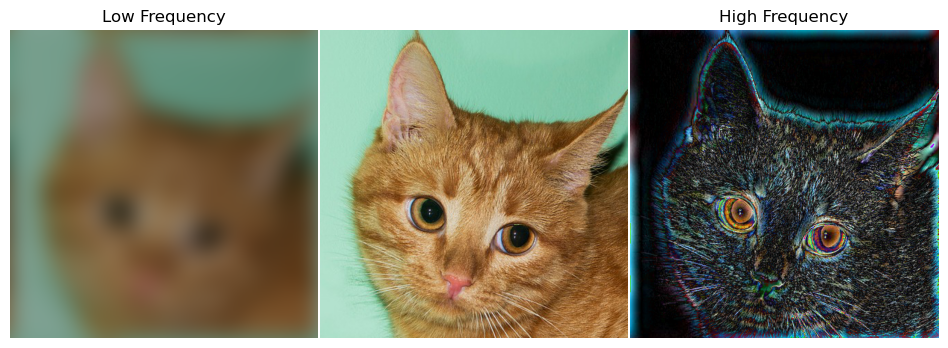

In [6]:
def plot_3_images(im_low, im, im_high):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(im_low)
    axes[0].axis('off')
    axes[0].set_title('Low Frequency')

    axes[1].imshow(im)
    axes[1].axis('off')

    axes[2].imshow(im_high)
    axes[2].axis('off')
    axes[2].set_title('High Frequency')


    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0, wspace=0)

    # Show the figure
    plt.show()

plot_3_images(img_cat_low, img_cat, img_cat_high)

In [7]:
# folder_path = "stargan-v2/cat/"
folder_path = "images/source/cat_org/"
num_images = 50
count = 0

# Get a sorted list of filenames in the folder based on the numbers within them
sorted_file_list = sorted(os.listdir(folder_path), key=lambda x: int(re.findall(r'\d+', x)[0]))

for i, filename in tqdm(enumerate(sorted_file_list)):
    if count >= num_images: break

    if filename.endswith(".png"):

        image_path = os.path.join(folder_path, filename)
        image = imread(image_path)

        # # Rename original image.
        # old_file = os.path.join(folder_path, filename)
        # new_file = os.path.join(folder_path, f"img_cat_org_{i}.png")
        # os.rename(old_file, new_file)
        
        # Apply the high/low pass filter and save the images.
        img_cat_low = pass_filter(image, 'low', 5)
        cat_low = Image.fromarray(img_cat_low)
        cat_low.save(f"images/source/cat_low/img_cat_low_{i}.png")

        img_cat_high = pass_filter(image, 'high', 10)
        cat_high = Image.fromarray(img_cat_high)
        cat_high.save(f"images/source/cat_high/img_cat_high_{i}.png")

        count += 1
        

50it [00:21,  2.31it/s]


### Run cycle diffusion (DDPM)

In [8]:
# Run to generate all dog images, can take multiple hours!
# !./experiment1_run.sh

'.' is not recognized as an internal or external command,
operable program or batch file.


### Comparing generated images with images that were used as input
### using the Structural Similarity Index Measure (SSIM).

In [9]:
from evaluation.utils import calculate_ssim

# Plot 2 images next to each other with the SSIM score printed underneath.
def plot_images(image1, image2, title):
    # Create a figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot the first image
    axes[0].imshow(image1)
    axes[0].axis('off')

    # Plot the second image
    axes[1].imshow(image2)
    axes[1].axis('off')

    # Add title above the images
    fig.suptitle(title, fontsize=16, y=0.95)

    # Add text below the images
    ssim_score = round(calculate_ssim(image1, image2), 3)
    fig.text(0.5, 0.05, f" SSIM: {ssim_score}", ha='center', fontsize=12)

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0, wspace=0)

    # Show the plot
    plt.show()


# Return max, min, mean and std of all values in the list.
def ssim_stats(list):
    scores_np = np.array(list)
    mean = np.mean(scores_np)
    std = np.std(scores_np)
    min_ = np.min(scores_np)
    max_ = np.max(scores_np)
    return mean, std, min_, max_

In [10]:
# Get a (sorted) list of image file names in the folder
src_cat_files = sorted([f for f in os.listdir("images/source/cat_org/")], key=lambda x: int(re.findall(r'\d+', x)[0]))
cat_high_files = sorted([f for f in os.listdir("images/source/cat_high/")], key=lambda x: int(re.findall(r'\d+', x)[0]))
cat_low_files = sorted([f for f in os.listdir("images/source/cat_low/")], key=lambda x: int(re.findall(r'\d+', x)[0]))
gen_dog_files = sorted([f for f in os.listdir("images/output/gen_dog_org/")], key=lambda x: int(re.findall(r'\d+', x)[0]))
gen_dog_high_files = sorted([f for f in os.listdir("images/output/gen_dog_high/")], key=lambda x: int(re.findall(r'\d+', x)[0]))
gen_dog_low_files = sorted([f for f in os.listdir("images/output/gen_dog_low/")], key=lambda x: int(re.findall(r'\d+', x)[0]))

In [11]:
# Select image number to show (number between 0 and 49)
im_num = 15

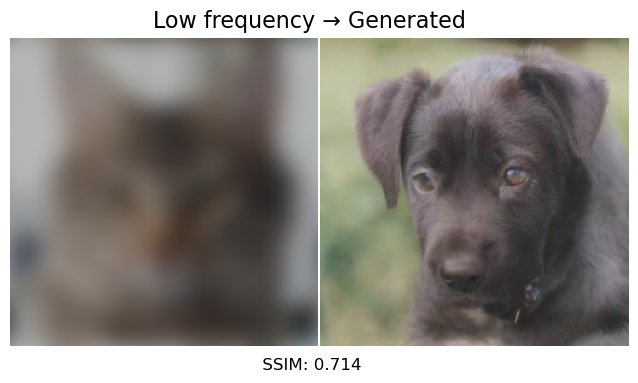

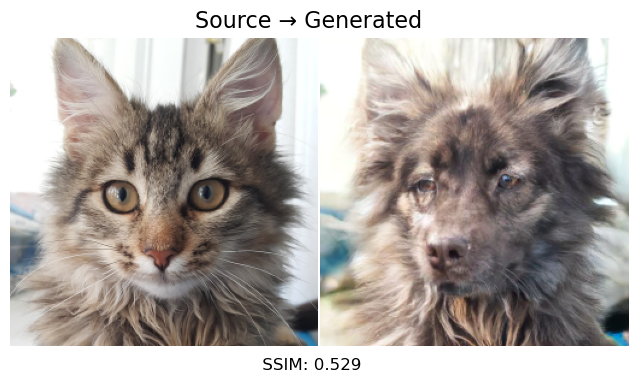

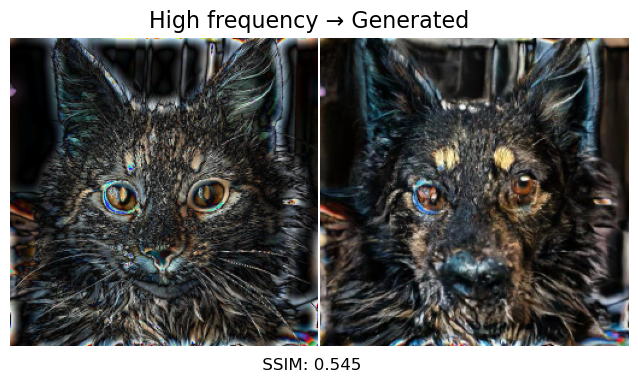

In [48]:
# List to store the scores
ssim_high = []
ssim_low = []
ssim_src = []

# Calculate SSIM scores between the cats and the generated dogs.
for i in range(len(src_cat_files)):
    src_cat_file = src_cat_files[i]
    src_cat_high_file = cat_high_files[i]
    src_cat_low_file = cat_low_files[i]

    src_cat_path = os.path.join("images/source/cat_org/", src_cat_file)
    src_cat_high_path = os.path.join("images/source/cat_high/", src_cat_high_file)
    src_cat_low_path = os.path.join("images/source/cat_low/", src_cat_low_file)

    src_cat = cv2.resize(imread(src_cat_path), (256, 256))
    src_cat_high = cv2.resize(imread(src_cat_high_path), (256, 256))
    src_cat_low = cv2.resize(imread(src_cat_low_path), (256, 256))

    gen_dog_file = gen_dog_files[i]
    gen_dog_high_file = gen_dog_high_files[i]
    gen_dog_low_file = gen_dog_low_files[i]

    gen_dog_path = os.path.join("images/output/gen_dog_org/", gen_dog_file)
    gen_dog_high_path = os.path.join("images/output/gen_dog_high/", gen_dog_high_file)
    gen_dog_low_path = os.path.join("images/output/gen_dog_low/", gen_dog_low_file)

    gen_dog = imread(gen_dog_path)
    gen_dog_high = imread(gen_dog_high_path)
    gen_dog_low = imread(gen_dog_low_path)

    ssim_high.append(calculate_ssim(src_cat_high, gen_dog_high))
    ssim_low.append(calculate_ssim(src_cat_low, gen_dog_low))
    ssim_src.append(calculate_ssim(src_cat, gen_dog))


    if i == im_num:
        plot_images(src_cat_low, gen_dog_low, 'Low frequency \u2192 Generated')
        plot_images(src_cat, gen_dog, 'Source \u2192 Generated')
        plot_images(src_cat_high, gen_dog_high, 'High frequency \u2192 Generated')


# Save the scores to a CSV file
csv_file = "scores1.csv"
header = ["SSIM High", "SSIM Low", "SSIM Source"]

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(zip(ssim_high, ssim_low, ssim_src))


mean_high, std_high, min_high, max_high = ssim_stats(ssim_high)
mean_low, std_low, min_low, max_low = ssim_stats(ssim_low)
mean_src, std_src, min_src, max_src = ssim_stats(ssim_src)

SSIM Scores - Source cats vs generated dogs
Mean: 0.5172
Standard Deviation: 0.0509
Min: 0.42954520785134526
Max: 0.625074350053939


SSIM Scores - Source (high) cats vs generated (high) dogs
Mean: 0.5113
Standard Deviation: 0.0385
Min: 0.40587189803810414
Max: 0.5922561403107811


SSIM Scores - Source (low) cats vs generated (low) dogs
Mean: 0.7386
Standard Deviation: 0.0430
Min: 0.6570333642894546
Max: 0.8426625824561857


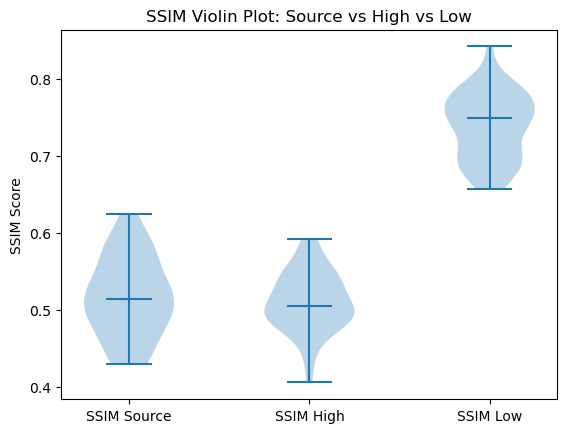

In [50]:
print("SSIM Scores - Source cats vs generated dogs")
print("Mean: {:.4f}".format(mean_src))
print("Standard Deviation: {:.4f}".format(std_src))
print("Min: {}".format(min_src))
print("Max: {}\n\n".format(max_src))

print("SSIM Scores - Source (high) cats vs generated (high) dogs")
print("Mean: {:.4f}".format(mean_high))
print("Standard Deviation: {:.4f}".format(std_high))
print("Min: {}".format(min_high))
print("Max: {}\n\n".format(max_high))

print("SSIM Scores - Source (low) cats vs generated (low) dogs")
print("Mean: {:.4f}".format(mean_low))
print("Standard Deviation: {:.4f}".format(std_low))
print("Min: {}".format(min_low))
print("Max: {}".format(max_low))


data = [ssim_src, ssim_high, ssim_low]

plt.violinplot(data, showmedians=True)
plt.xticks([1, 2, 3], ['SSIM Source', 'SSIM High', 'SSIM Low'])
plt.title('SSIM Violin Plot: Source vs High vs Low')
plt.ylabel('SSIM Score')
plt.show()

### Comparing generated high/low filtered dog images with dog images generated from the source

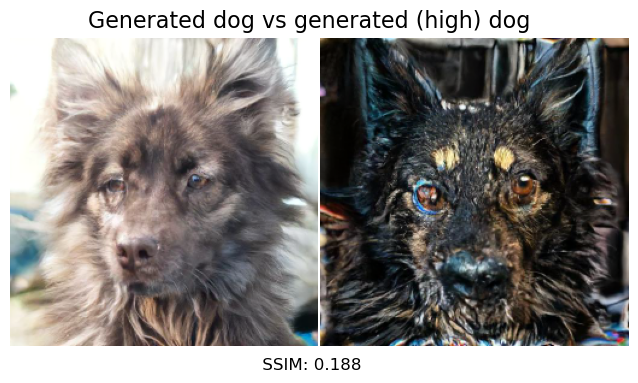

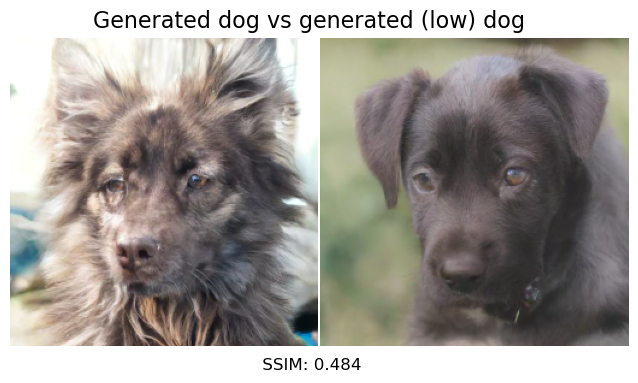

In [44]:
# List to store the scores
scores_high = []
scores_low = []

# Calculate SSIM scores between original generated image and low / high pass filtered generated images
for i in range(len(gen_dog_files)):
    gen_dog_file = gen_dog_files[i]
    gen_dog_high_file = gen_dog_high_files[i]
    gen_dog_low_file = gen_dog_low_files[i]

    gen_dog_path = os.path.join("images/output/gen_dog_org/", gen_dog_file)
    gen_dog_high_path = os.path.join("images/output/gen_dog_high/", gen_dog_high_file)
    gen_dog_low_path = os.path.join("images/output/gen_dog_low/", gen_dog_low_file)

    gen_dog = imread(gen_dog_path)
    gen_dog_high = imread(gen_dog_high_path)
    gen_dog_low = imread(gen_dog_low_path)
    
    scores_high.append(calculate_ssim(gen_dog, gen_dog_high))
    scores_low.append(calculate_ssim(gen_dog, gen_dog_low))

    if i == im_num:
        plot_images(gen_dog, gen_dog_high, 'Generated dog vs generated (high) dog')
        plot_images(gen_dog, gen_dog_low, 'Generated dog vs generated (low) dog')



# Save the scores to a CSV file
csv_file = "scores2.csv"
header = ["SSIM High", "SSIM Low"]

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(zip(scores_high, scores_low))


mean_high, std_high, min_high, max_high = ssim_stats(scores_high)
mean_low, std_low, min_low, max_low = ssim_stats(scores_low)

SSIM Scores - Generated images vs generated high pass filter images
Mean: 0.2347
Standard Deviation: 0.0744
Min: 0.11620839458466925
Max: 0.4197233336347957


SSIM Scores - Generated images vs generated low pass filter images
Mean: 0.5364
Standard Deviation: 0.0958
Min: 0.3215287620156608
Max: 0.7048388262558292


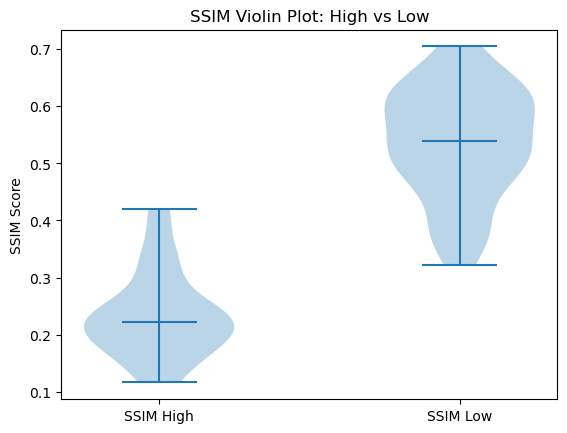

In [45]:
print("SSIM Scores - Generated images vs generated high pass filter images")
print("Mean: {:.4f}".format(mean_high))
print("Standard Deviation: {:.4f}".format(std_high))
print("Min: {}".format(min_high))
print("Max: {}\n\n".format(max_high))

print("SSIM Scores - Generated images vs generated low pass filter images")
print("Mean: {:.4f}".format(mean_low))
print("Standard Deviation: {:.4f}".format(std_low))
print("Min: {}".format(min_low))
print("Max: {}".format(max_low))

data = [scores_high, scores_low]

plt.violinplot(data, showmedians=True)
plt.xticks([1, 2], ['SSIM High', 'SSIM Low'])
plt.title('SSIM Violin Plot: High vs Low')
plt.ylabel('SSIM Score')
plt.show()

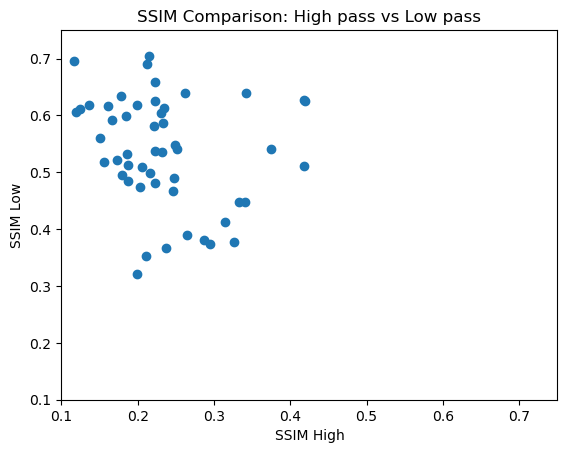

In [47]:
# Create a scatter plot
plt.scatter(scores_high, scores_low)

# Set plot title and labels
plt.title('SSIM Comparison: High pass vs Low pass')
plt.xlabel('SSIM High')
plt.ylabel('SSIM Low')

plt.xlim(0.1, 0.75)
plt.ylim(0.1, 0.75)

# Show the plot
plt.show()

## Compare original cat with generated dog and generated (low) dog

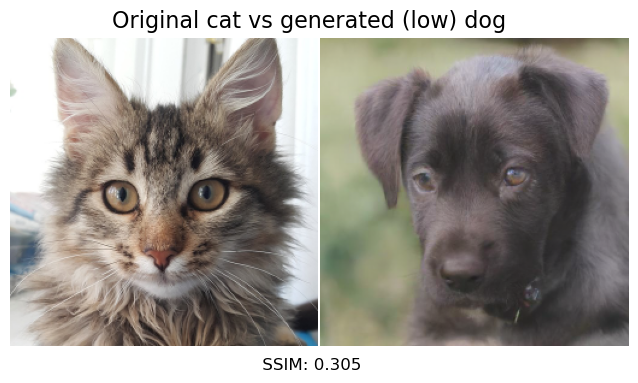

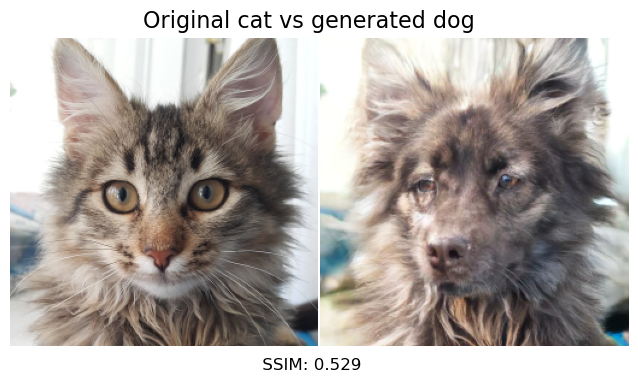

In [39]:
# List to store the scores
ssim_src = []
ssim_low = []

# Calculate SSIM scores between original generated image and low / high pass filtered generated images
for i in range(len(gen_dog_files)):
    src_cat_file = src_cat_files[i]
    gen_dog_file = gen_dog_files[i]
    gen_dog_low_file = gen_dog_low_files[i]

    src_cat_path = os.path.join("images/source/cat_org/", src_cat_file)
    gen_dog_path = os.path.join("images/output/gen_dog_org/", gen_dog_file)
    gen_dog_low_path = os.path.join("images/output/gen_dog_low/", gen_dog_low_file)

    src_cat = cv2.resize(imread(src_cat_path), (256, 256))
    gen_dog = imread(gen_dog_path)
    gen_dog_low = imread(gen_dog_low_path)
    
    ssim_low.append(calculate_ssim(src_cat, gen_dog_low))
    ssim_src.append(calculate_ssim(src_cat, gen_dog))

    if i == im_num:
        plot_images(src_cat, gen_dog_low, 'Original cat vs generated (low) dog')
        plot_images(src_cat, gen_dog, 'Original cat vs generated dog')



# Save the scores to a CSV file
csv_file = "scores3.csv"
header = ["SSIM low", "SSIM source"]

with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(zip(ssim_low, ssim_src))


mean_low, std_low, min_low, max_low = ssim_stats(ssim_low)
mean_src, std_src, min_src, max_src = ssim_stats(ssim_src)

SSIM Scores - Original cats vs generated low pass filtered dog
Mean: 0.3317
Standard Deviation: 0.0883
Min: 0.12333978595924094
Max: 0.5211740835153078


SSIM Scores - Original cats vs generated dog
Mean: 0.5172
Standard Deviation: 0.0509
Min: 0.42954520785134526
Max: 0.625074350053939


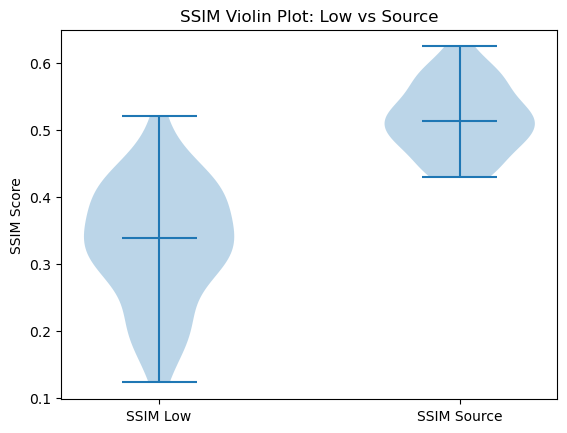

In [42]:
print("SSIM Scores - Original cats vs generated low pass filtered dog")
print("Mean: {:.4f}".format(mean_low))
print("Standard Deviation: {:.4f}".format(std_low))
print("Min: {}".format(min_low))
print("Max: {}\n\n".format(max_low))

print("SSIM Scores - Original cats vs generated dog")
print("Mean: {:.4f}".format(mean_src))
print("Standard Deviation: {:.4f}".format(std_src))
print("Min: {}".format(min_src))
print("Max: {}".format(max_src))


data = [ssim_low, ssim_src]

plt.violinplot(data, showmedians=True)
plt.xticks([1, 2], ['SSIM Low', 'SSIM Source'])
plt.title('SSIM Violin Plot: Low vs Source')
plt.ylabel('SSIM Score')
plt.show()